# Regularized logistic regression 

In this part of the exercise, we will implement regularized logistic regression
to predict whether microchips from a fabrication plant passes quality assurance (QA).

the data we will work with has two features (result of two tests), and the label is the status of every microchip 
(accepted or rejected).

first we will use `pandas` to load our data:

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fmin_bfgs
%matplotlib inline

dataset = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'status'])
print(dataset.shape)
print(dataset.head())

(118, 3)
      test1    test2  status
0  0.051267  0.69956       1
1 -0.092742  0.68494       1
2 -0.213710  0.69225       1
3 -0.375000  0.50219       1
4 -0.513250  0.46564       1


# Visualizing the data 
Before starting to implement any learning algorithm, it is always good to visualize the data if possible.

we will use 2-dimensional plot where the axes are the result of two tests, the rejected and accepted examples are shown with different markers. 

we will use `matplotlib.pyplot` to complete this task


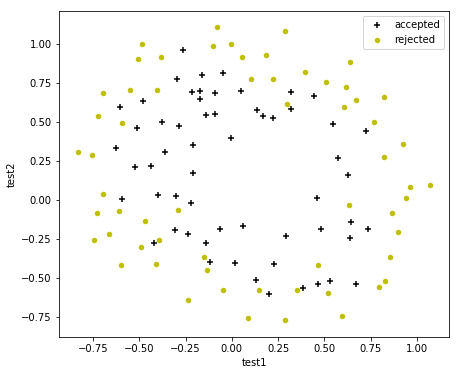

In [2]:
pos = dataset[(dataset['status'] == 1)]
neg = dataset[(dataset['status'] == 0)]

figure = plt.figure(figsize=(7, 6))
ax = figure.gca()

pos.plot.scatter(x='test1', y='test2', ax=ax, c='k', s=40,
                 marker='+', label='accepted')
neg.plot.scatter(x='test1', y='test2', ax=ax, c='y',
                 marker='o', label='rejected')

plt.legend()
plt.show()

**Note** from plot our dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straightforward application of logistic regression will not perform well on this dataset
since logistic regression will only be able to find a linear decision boundary.

# Feature mapping

One way to fit the data better is to create more features from each data point.

so now we will implement function to map the features into all polynomial terms of x1 and x2 up to the sixth power.

In [3]:
features = np.array(dataset[['test1', 'test2']]).transpose()
label = np.array(dataset['status'])

print('before mapping ' + str(features.shape))

X1 = features[0, :]
X2 = features[1, :]


def features_mapping(X1, X2, degree=6):
    out = []
    for i in range(1, degree + 1):
        for j in range(i + 1):
            out.append([(x1 ** (i - j)) * (x2 ** j) 
                       for x1, x2 in zip(X1, X2)])
    
    return np.array(out)


mapped_features = features_mapping(X1, X2, 6)

print('after mapping ' + str(mapped_features.shape))

before mapping (2, 118)
after mapping (27, 118)


As a result of this mapping, our vector of two features (the scores on
two QA tests) has been transformed into a 27-dimensional vector. 

# implementation
for logistic regression The hypothesis is defined as:

h(x) = g(theta\` * x)

where g is the sigmoid function

g(z) = 1/(1+e^(-z))

so first we will need to implement this function so we can use it later.

In [4]:
def sigmoid(value):
    exp = np.exp(-value)
    denominator = np.add(1, exp)
    return np.divide(1, denominator)

# Cost function and gradient

Now we will implement code to compute the cost function and gradient for regularized logistic regression.

the cost function in regularized logistic regression is:

J(θ) = (1 / m) ∑ \[(-y (log(y')) - (1 - y)(log(1 - y'))\] + (λ / 2 * m) ∑θ

where λ is the regularization parameter, and y' is the hypothesis.

Note that you should not regularize the parameter θ0.

so gradient for theta0 is:

gradient = (1 / m) ∑(y' - y) X

and regularized gradient:

gradient = (1 / m) ∑(y' - y) X + (λ / m) θ

In [5]:
def cost(x, y, theta, reg_para=1):
    m = x.shape[0]
    pre_y = sigmoid(np.dot(x, theta.transpose()))
    cost = (1 / m) * sum([(np.dot(-y.transpose(), np.log(pre_y)) - 
                          np.dot((1 - y).transpose(), np.log(1 - pre_y)))])
    reg = (reg_para / (2 * m)) * np.sum([x ** 2 for x in theta[1:]])
    return cost + reg


def gradient(x, y, theta, reg_para=1):
    m = x.shape[0]
    pre_y = sigmoid(np.dot(x, theta.transpose()))
    grad = (1 / m) * np.dot((pre_y - y).transpose(), x)
    reg = [0]
    reg += [(reg_para / m) * x for x in theta[1:]]
    return np.add(grad, reg)

# Learning parameters using fmin_bfgs

in this part we will use `fmin_bfgs` from `scipy` to find optimal parameters

[to read more about scipy.optimize.fmin_bfgs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_bfgs.html)

first we will prepare our features and label to feed it to this function 

- first we will add another dimension to our data to accommodate the theta0 intercept term. 

- intialize theta values to zeros 

- we will define two functions ( `costfun` , `gradfun`) that take theta as parameter and return our cost and gradient function.

- we will give `costfun`, `gradfun` and intial theta values to `fmin_bfgs` function then print optimal theta values 


**Note** we initialized max iteration to 400 so that `fmin_bfgs` will run for at most 400 steps before it terminates.


**Note**  our objective function is cost function to be minimized

In [6]:
mapped_features = features_mapping(X1, X2, 6).transpose()

# intialize theta values
theta_init = np.zeros((1, mapped_features.shape[1] + 1),
                      dtype='float64')

# add another dimention
mapped_features = np.concatenate([np.ones((mapped_features.shape[0], 1),
                                          dtype='float64'),
                                 mapped_features], axis=1)


def costfun(theta_init):
    return cost(mapped_features, label, theta_init)


def gradfun(theta_init):
    return gradient(mapped_features, label, theta_init)


opti_theta = np.array(fmin_bfgs(costfun, x0=theta_init, fprime=gradfun, maxiter=400))


Optimization terminated successfully.
         Current function value: 0.529003
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48


**Note** the function found optimal theta values after 47 iterations.

# Evaluating logistic regression

After learning the parameters, you can use the model to predict whether a particular microchip will be accepted or rejected.

now we will fit the model to our features , then we will implement predict function that takes the hypothesis values, threshold and returns 0 or 1.

In [7]:
hypothesis = sigmoid(np.dot(mapped_features, opti_theta.transpose()))

def predict(pre_y, threshold):
    return np.array([1 if x > threshold else 0 for x in pre_y])


prediction = predict(hypothesis, 0.5)
print(prediction[:5])

[1 1 1 1 1]


now we will report the training accuracy of the classifier by computing the percentage of examples it got correct.



In [8]:
correct = 0 
total = 0 

for idx in range(label.shape[0]):
    if prediction[idx] == label[idx]:
        correct +=1 
    total += 1

    accuracy = (correct / total) * 100

print('Accuracy = %0.2f' %accuracy)

Accuracy = 83.05


that means our model classified 83.05 of the cases correctly.

# Plotting the decision boundary

now we will visualize our classifier with our data to see how good it fits.

- First we will define grid range 
- then we will evaluate z = theta*x over the grid
- eventually we will use contour from `matplotlib` to plot our decision boundary 

[to read more about matplotlib.pyplot.contour](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.contour.html)

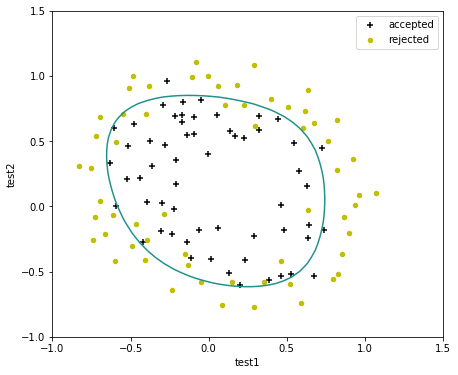

In [9]:
# plotting data
pos = dataset[(dataset['status'] == 1)]
neg = dataset[(dataset['status'] == 0)]

figure = plt.figure(figsize=(7, 6))
ax = figure.gca()

pos.plot.scatter(x='test1', y='test2', ax=ax, c='k', s=40,
                 marker='+', label='accepted')
neg.plot.scatter(x='test1', y='test2', ax=ax, c='y',
                 marker='o', label='rejected')

# define grid range
u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)

z = np.zeros(shape=(len(u), len(v)))
# evaluate z = theta*x over the grid
for i in range(len(u)):
    for j in range(len(v)):
        feature = features_mapping(np.array([u[i]]),
                                   np.array([v[j]])).transpose()
        feature = np.concatenate([np.ones((feature.shape[0], 1),
                                          dtype='float64'),
                                 feature], axis=1)
        z[i, j] = np.dot(feature, opti_theta)

z = z.transpose()
ax.contour(u, v, z, 0)

plt.legend()
plt.show()

# try out different regularization parameters :

In this part of the exercise, we will get to try out different regularization
parameters for the dataset to understand how regularization prevents over-fitting.

         Current function value: 0.263499
         Iterations: 400
         Function evaluations: 401
         Gradient evaluations: 401


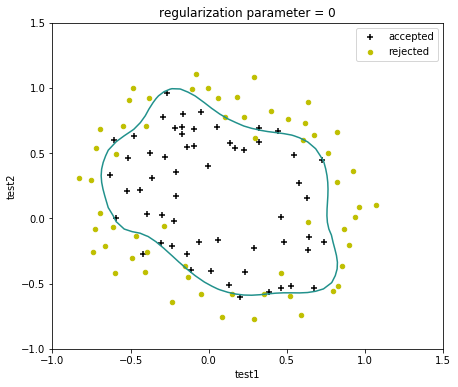

Optimization terminated successfully.
         Current function value: 0.529003
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48


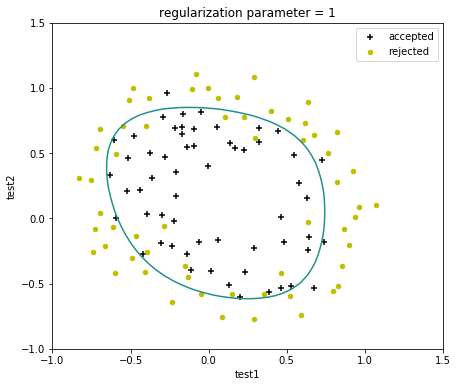

Optimization terminated successfully.
         Current function value: 0.686484
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8


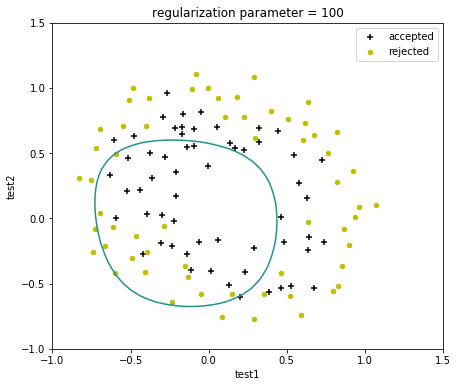

In [10]:
parameters = [0, 1, 100]

for parameter in parameters:
    def costfun(theta_init):
        return cost(mapped_features, label, theta_init, parameter)


    def gradfun(theta_init):
        return gradient(mapped_features, label, theta_init, parameter)


    opti_theta = np.array(fmin_bfgs(costfun, x0=theta_init, fprime=gradfun, maxiter=400)) 
    # plotting data
    pos = dataset[(dataset['status'] == 1)]
    neg = dataset[(dataset['status'] == 0)]

    figure = plt.figure(figsize=(7, 6))
    ax = figure.gca()

    pos.plot.scatter(x='test1', y='test2', ax=ax, c='k', s=40,
                     marker='+')
    neg.plot.scatter(x='test1', y='test2', ax=ax, c='y',
                     marker='o')

    # define grid range
    u = np.linspace(-1, 1.5, 50)
    v = np.linspace(-1, 1.5, 50)

    z = np.zeros(shape=(len(u), len(v)))
    # evaluate z = theta*x over the grid
    for i in range(len(u)):
        for j in range(len(v)):
            feature = features_mapping(np.array([u[i]]),
                                       np.array([v[j]])).transpose()
            feature = np.concatenate([np.ones((feature.shape[0], 1),
                                              dtype='float64'),
                                     feature], axis=1)
            z[i, j] = np.dot(feature, opti_theta)

    z = z.transpose()
    ax.contour(u, v, z, 0)

    plt.legend(['accepted', 'rejected'])
    ax.set_title('regularization parameter = ' + str(parameter))
    plt.show()

First we note when regularization parameter = 0 our model is more complex and have overfitting problem.

With a larger regularization parameter ( = 1 ), we see a plot that shows an simpler decision
boundary which still separates the positives and negatives fairly well.

though when regularization parameter is too large (= 100) our model will have high bias (underfitting).